<a href="https://colab.research.google.com/github/Benylaode/clasification-plant/blob/main/seed_clasisfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from fastai.vision.all import *
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fastai.vision.all import cnn_learner
from torchvision.models import resnet50
from torch import nn
from fastai.callback.core import Callback
import torch
import torch.onnx
import os
from IPython import get_ipython
import subprocess
import torch
import numpy as np
from tensorflow import keras
from torch.serialization import add_safe_globals
from torch.nn import Sequential
import torch
import numpy as np
import os


drive.mount('/content/drive')

Mounted at /content/drive


**mengambil data dari drive**
karena data disimpan di drive maka kita harus mengaksesnya dulu

In [ ]:
data_dir = '/content/drive/MyDrive/plant-seedlings-classification/train'
test_dir = '/content/drive/MyDrive/plant-seedlings-classification/test'

**meliohat sebaran data setiap label**

In [ ]:
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts[class_name] = count

# Tampilkan hasilnya
for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} gambar")

Black-grass: 263 gambar
Charlock: 390 gambar
Cleavers: 287 gambar
Common Chickweed: 611 gambar
Common wheat: 221 gambar
Fat Hen: 475 gambar
Loose Silky-bent: 654 gambar
Maize: 221 gambar
Scentless Mayweed: 516 gambar
Shepherds Purse: 231 gambar
Small-flowered Cranesbill: 496 gambar
Sugar beet: 385 gambar


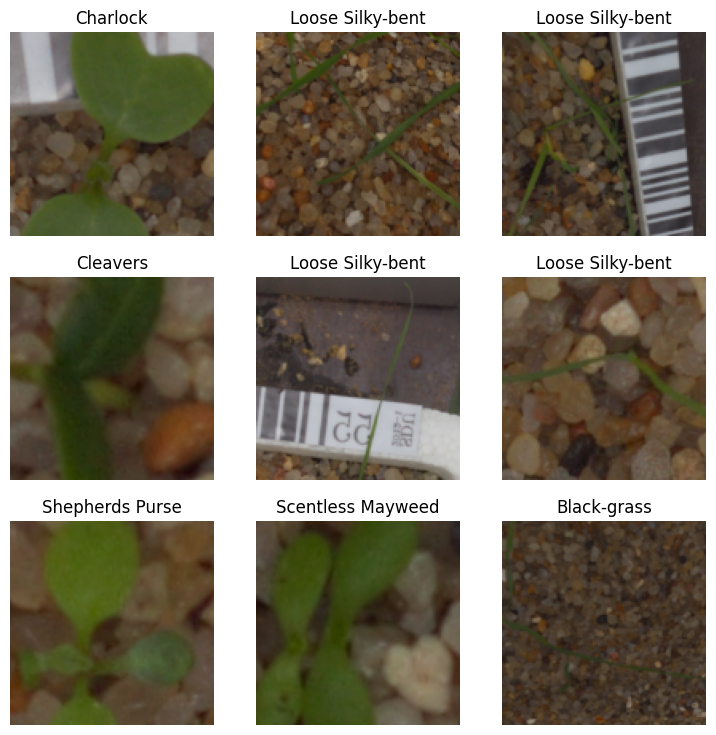

In [ ]:
from fastai.vision.all import *

path = data_dir

rand_seed = None

def get_dls(size=128, bs=128):
    db = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        splitter=RandomSplitter(seed=rand_seed),
        item_tfms=Resize(280),
        batch_tfms=aug_transforms(size=size, min_scale=0.3)
    )
    return db.dataloaders(path, bs=bs)

dls = get_dls(size=128, bs=128)
dls.show_batch()

**mendefinisika model yang sedang di coba**

menggunakan model dasar resnet50 yang sudah memenuhi syara conv2d dan pooling layer

In [ ]:
base_model = resnet50(pretrained=True)
base_model.fc = nn.Identity()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [ ]:
n_classes = dls.c

model = nn.Sequential(
    base_model,
    nn.Flatten(),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, n_classes)
)


**melatih dengan menggunakan learner **

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn.fit_one_cycle(10, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.713117,1.092107,0.647368,30:19
1,1.030301,1.465068,0.658947,01:15
2,0.798809,1.233792,0.722105,01:13
3,0.620790,0.544076,0.833684,01:13
4,0.486439,0.873216,0.765263,01:15
5,0.408915,0.544303,0.814737,01:12
6,0.342692,0.306661,0.902105,01:14
7,0.265330,0.207463,0.926316,01:15
8,0.207126,0.138792,0.944211,01:13
9,0.162779,0.136855,0.950526,01:13


**evalusia pelatihan model**

In [ ]:
train_losses = learn.recorder.losses
valid_metrics = learn.recorder.values

print(valid_metrics)

[[1.7131165266036987, 1.0921072959899902, 0.6473684310913086], [1.0303006172180176, 1.4650678634643555, 0.6589473485946655], [0.7988093495368958, 1.2337920665740967, 0.7221052646636963], [0.6207900643348694, 0.5440759062767029, 0.8336842060089111], [0.4864386022090912, 0.8732157349586487, 0.7652631402015686], [0.40891483426094055, 0.5443031787872314, 0.8147368431091309], [0.3426918685436249, 0.30666130781173706, 0.9021052718162537], [0.2653299868106842, 0.20746275782585144, 0.9263157844543457], [0.2071264237165451, 0.1387917399406433, 0.9442105293273926], [0.1627790629863739, 0.13685466349124908, 0.9505262970924377]]


In [ ]:
val_accuracies = [v[2] for v in valid_metrics]

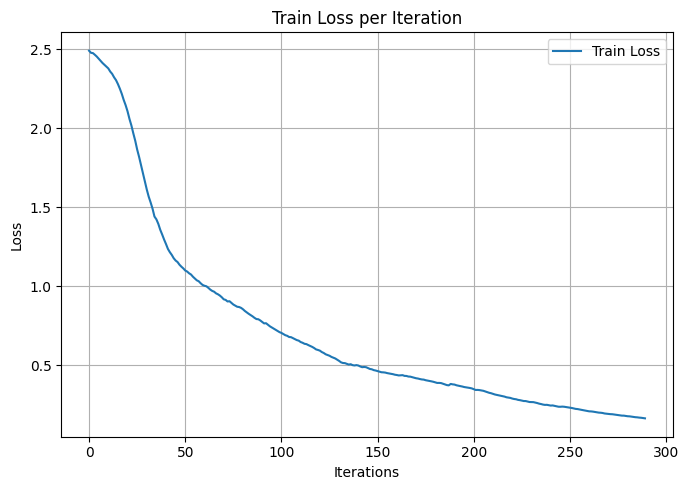

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5)) # Ubah menjadi 1, 1 untuk satu subplot

axs.plot(range(len(train_losses)), train_losses, label='Train Loss') # Akses langsung axs
axs.set_title("Train Loss per Iteration")
axs.set_xlabel("Iterations")
axs.set_ylabel("Loss")
axs.grid(True)
axs.legend()

plt.tight_layout()
plt.show()

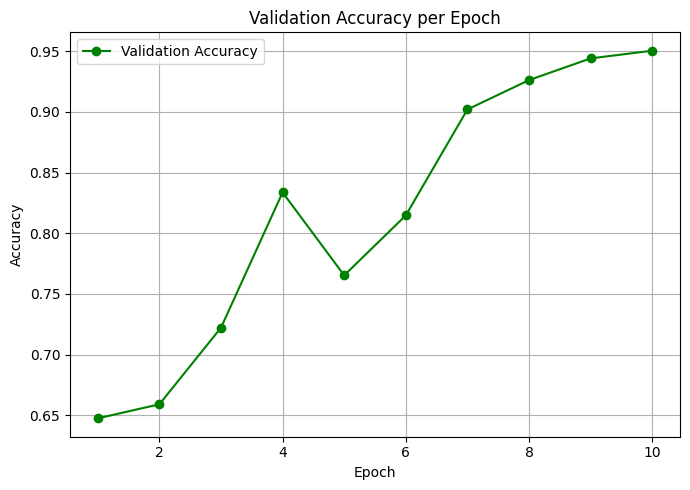

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))

axs.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
axs.set_title("Validation Accuracy per Epoch")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
axs.grid(True)
axs.legend()

plt.tight_layout()
plt.show()

**testing model di data**

In [ ]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9526315927505493

**melihat cm dari data yang sudah di test**

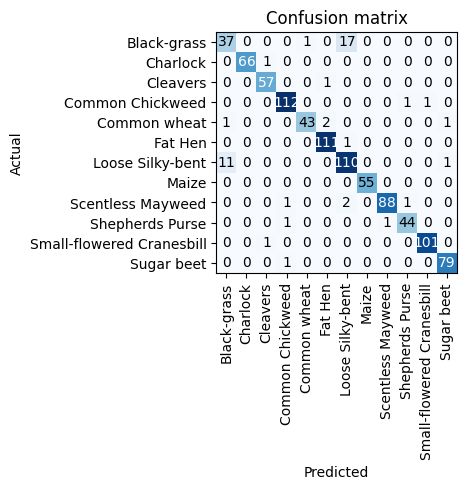

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**melakukan penesuan da penyimpanan data sesuai format*

In [ ]:
torch.save(model, "pytorch_model.pth")

In [ ]:
add_safe_globals({"Sequential": Sequential})

model = torch.load("pytorch_model.pth", map_location=torch.device("cpu"), weights_only=False)
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224)
torch_output = model(dummy_input)
output_dim = torch_output.shape[-1]

keras_model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Keras pakai NHWC: height, width, channel
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),  # Dummy layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(output_dim, activation='softmax')
])

keras_model.compile()

keras_model.export("submission/saved_model")


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  134859491704080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134859491699856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134859491694864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134859491695440: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/tfjs_model", exist_ok=True)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

with open("submission/tflite/label.txt", "w") as f:
    f.write("Black-grass\nCharlock\nCommon Chickweed\nCommon wheat\nFat Hen\nLoose Silky-bent\nMaizen\nScentless Mayweed\nShepherds Purse\nShepherds Purse\nSmall-flowered Cranesbill\nSugar beet\n")  # ubah sesuai labelmu



In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  submission/saved_model \
  submission/tfjs_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-20 23:36:34.280801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747784194.302059   15918 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

In [ ]:
!zip -r submission.zip submission
from google.colab import files
files.download("submission.zip")


  adding: submission/ (stored 0%)
  adding: submission/tfjs_model/ (stored 0%)
  adding: submission/tfjs_model/group1-shard1of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard8of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard16of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard5of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard15of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard10of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard6of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard18of19.bin (deflated 10%)
  adding: submission/tfjs_model/model.json (deflated 79%)
  adding: submission/tfjs_model/group1-shard9of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard3of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard2of19.bin (deflated 10%)
  adding: submission/tfjs_model/group1-shard17of19.bin (deflated 10%)
  adding: submission/tfjs_mode

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>